In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [48]:
df = pd.read_csv("confirmed_diff.csv")
df.dropna()
subset = df[df['region'] == "Wilson - North Carolina"]
testS = df[df['region'] == "Orange - North Carolina"]

In [78]:
def organize_data(x, days_offset=5):
    x = x.copy()
    x['id'] = range(len(x))
    x['norm-0'] = (x['Value'] - x['Value'].mean()) / x['Value'].std()
    for item in range(days_offset):
        x['norm-%s'%str(item+1)] = x.shift(periods=(1+item))['norm-0']
#     x['norm-1'] = x.shift(periods=1)['norm']
    out = x[days_offset:]
    return out

In [138]:
OFFSET = 10
n_subset = organize_data(subset, OFFSET)[['norm-%s'%str(x) for x in range(OFFSET+1)]]
t_subset = organize_data(testS, OFFSET)[['norm-%s'%str(x) for x in range(OFFSET+1)]]
train_labels = n_subset.pop("norm-0")
test_labels = t_subset.pop("norm-0")

In [139]:
def build_model(dt, offset):
    df = dt.copy()
#    df = dt['norm-0'].copy()
    
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(df.keys())]), 
        layers.Dense(64, activation='relu'), 
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', 
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

In [140]:
model = build_model(n_subset, OFFSET)

In [141]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,929
Trainable params: 4,929
Non-trainable params: 0
_________________________________________________________________


In [142]:
example_batch = n_subset.loc[-10:, ['norm-%s'%str(item+1) for item in range(OFFSET)]].copy()
# example_batch = n_subset.loc[n_subset['id'] >= 73, 'norm-0'].copy()
ex_result = model.predict(example_batch)
ex_result

array([[-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484250e-01],
       [-1.8484250e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],
       [-1.8484248e-01],


In [143]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print("")
        print(".", end="")

EPOCHS = 1000
history = model.fit(n_subset, train_labels, epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[PrintDot()])
            


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [144]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.000115,0.008204,0.000115,0.014558,0.100221,0.014558,995
996,0.000257,0.014058,0.000257,0.008778,0.082087,0.008778,996
997,0.000180,0.010914,0.000180,0.008700,0.081439,0.008700,997
998,0.000246,0.013697,0.000246,0.017902,0.110456,0.017902,998
999,0.000759,0.024370,0.000759,0.008787,0.083655,0.008787,999


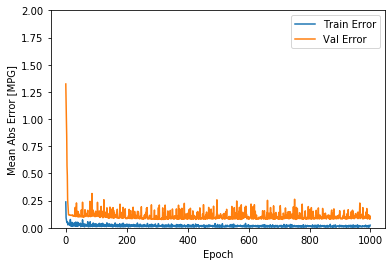

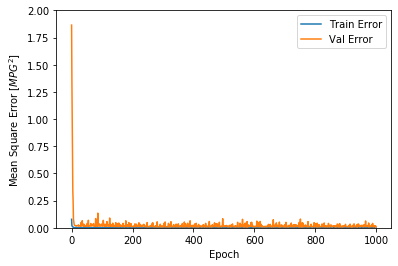

In [145]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 10])
# plt.ylabel('MAE [MPG]')


def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
             label = 'Val Error')
    plt.ylim([0,2])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
             label = 'Val Error')
    plt.ylim([0,2])
    plt.legend()
    plt.show()


plot_history(history)


............................................

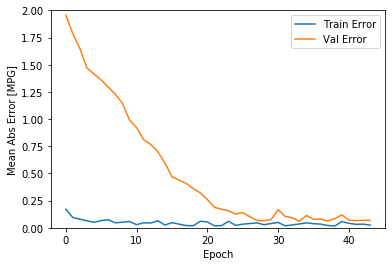

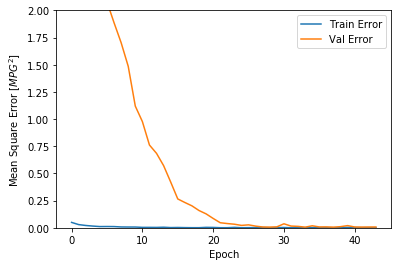

In [146]:
model = build_model(n_subset, OFFSET)
early_stop=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history=model.fit(n_subset, train_labels, epochs=EPOCHS,
                 validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [147]:
loss, mae, mse = model.evaluate(t_subset, test_labels, verbose=2)
print("Testing set mean abs error: {:5.2f} MPG".format(mae))

92/92 - 0s - loss: 0.0055 - mean_absolute_error: 0.0578 - mean_squared_error: 0.0055
Testing set mean abs error:  0.06 MPG


In [148]:
model.predict(n_subset.tail(2))

array([[2.563431 ],
       [2.6362739]], dtype=float32)

In [149]:
organize_data(subset)

,Unnamed: 0,Admin2,Province_State,Country_Region,Lat,Long_,Date,Value,region,Month,Day,diff,id,norm-0,norm-1,norm-2,norm-3,norm-4,norm-5
324365,138728,Wilson,North Carolina,US,35.706255,-77.917978,1/27/2020,0,Wilson - North Carolina,1,27,0.0,5,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324366,138729,Wilson,North Carolina,US,35.706255,-77.917978,1/28/2020,0,Wilson - North Carolina,1,28,0.0,6,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324367,138730,Wilson,North Carolina,US,35.706255,-77.917978,1/29/2020,0,Wilson - North Carolina,1,29,0.0,7,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324368,138731,Wilson,North Carolina,US,35.706255,-77.917978,1/30/2020,0,Wilson - North Carolina,1,30,0.0,8,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324369,138732,Wilson,North Carolina,US,35.706255,-77.917978,1/31/2020,0,Wilson - North Carolina,1,31,0.0,9,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324370,138733,Wilson,North Carolina,US,35.706255,-77.917978,2/1/2020,0,Wilson - North Carolina,2,1,0.0,10,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324371,138734,Wilson,North Carolina,US,35.706255,-77.917978,2/2/2020,0,Wilson - North Carolina,2,2,0.0,11,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324372,138735,Wilson,North Carolina,US,35.706255,-77.917978,2/3/2020,0,Wilson - North Carolina,2,3,0.0,12,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324373,138736,Wilson,North Carolina,US,35.706255,-77.917978,2/4/2020,0,Wilson - North Carolina,2,4,0.0,13,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
324374,138737,Wilson,North Carolina,US,35.706255,-77.917978,2/5/2020,0,Wilson - North Carolina,2,5,0.0,14,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904,-0.576904
